In [1]:
!pip install pytorch matplotlib numpy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch


  DEPRECATION: Building 'pytorch' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'pytorch'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 35, in <module>
        File "C:\Users\Usuario\AppData\Local\Temp\pip-install-_3cikq_4\pytorch_3790aac999754d548cbb21c6293b46a1\setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyT

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [14]:
x_min, x_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0
nu = 0.01 / np.pi


N_f = 10000  
N_0 = 200    
N_b = 200    


X_f = np.random.rand(N_f, 2)
X_f[:, 0] = X_f[:, 0] * (x_max - x_min) + x_min  # x in [-1, 1]
X_f[:, 1] = X_f[:, 1] * (t_max - t_min) + t_min    # t in [0, 1]


x0 = np.linspace(x_min, x_max, N_0)[:, None]
t0 = np.zeros_like(x0)
u0 = -np.sin(np.pi * x0)


tb = np.linspace(t_min, t_max, N_b)[:, None]
xb_left = np.ones_like(tb) * x_min
xb_right = np.ones_like(tb) * x_max
ub_left = np.zeros_like(tb)
ub_right = np.zeros_like(tb)


X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)
x0 = torch.tensor(x0, dtype=torch.float32)
t0 = torch.tensor(t0, dtype=torch.float32)
u0 = torch.tensor(u0, dtype=torch.float32)
tb = torch.tensor(tb, dtype=torch.float32)
xb_left = torch.tensor(xb_left, dtype=torch.float32)
xb_right = torch.tensor(xb_right, dtype=torch.float32)
ub_left = torch.tensor(ub_left, dtype=torch.float32)
ub_right = torch.tensor(ub_right, dtype=torch.float32)


In [13]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
       
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)
       
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)


layers = [2, 50, 50, 50, 50, 1]
model = PINN(layers)
print(model)


PINN(
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")


Using device: cpu


In [11]:
def pde_residual(model, X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    u = model(torch.cat([x, t], dim=1))
   
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
   
    f = u_t + u * u_x - nu * u_xx
    return f


def loss_func(model):
    f_pred = pde_residual(model, X_f.to(device))
    loss_f = torch.mean(f_pred**2)
   
    u0_pred = model(torch.cat([x0.to(device), t0.to(device)], dim=1))
    loss_0 = torch.mean((u0_pred - u0.to(device))**2)
   
    u_left_pred = model(torch.cat([xb_left.to(device), tb.to(device)], dim=1))
    u_right_pred = model(torch.cat([xb_right.to(device), tb.to(device)], dim=1))
    loss_b = torch.mean(u_left_pred**2) + torch.mean(u_right_pred**2)
   
    loss = loss_f + loss_0 + loss_b
    return loss, loss_f, loss_0, loss_b

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 5000


for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss, lossf, loss0, losb = loss_func(model)
    loss.backward()
    optimizer.step()
   
    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {loss.item():.5e}, tLoss_f: {lossf.item():.5e}, Loss_t: {loss0.item():.5e + osb.item():.5e}')
       
print("Training complete!")


Epoch 500/5000, Loss: 1.12865e-01
Epoch 1000/5000, Loss: 9.48294e-02
Epoch 1500/5000, Loss: 8.52894e-02
Epoch 2000/5000, Loss: 7.34314e-02
Epoch 2500/5000, Loss: 3.88413e-02
Epoch 3000/5000, Loss: 1.31738e-02
Epoch 3500/5000, Loss: 9.36220e-03
Epoch 4000/5000, Loss: 7.30691e-03
Epoch 4500/5000, Loss: 9.43913e-03
Epoch 5000/5000, Loss: 5.24256e-03
Training complete!


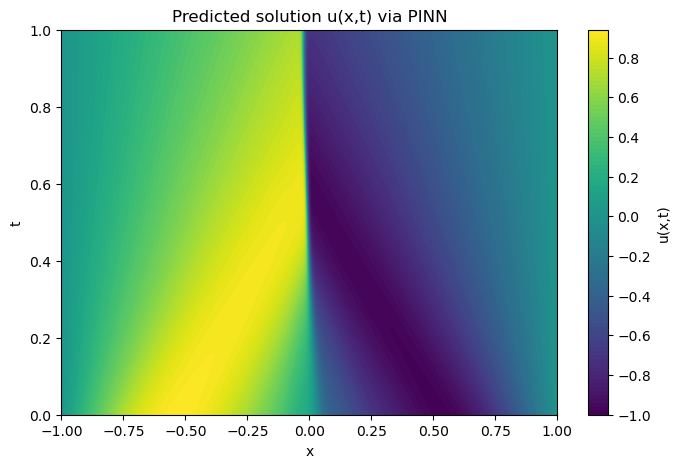

Text(0.5, 1.0, 'Predicted solution u(x,t) at different time slices')

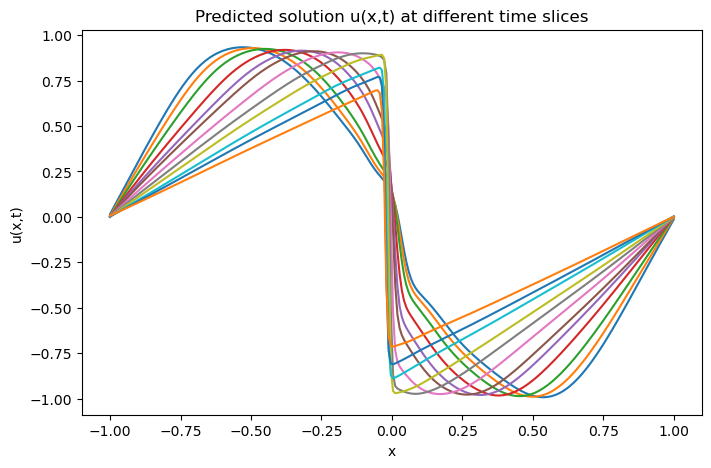

In [20]:
N_x, N_t = 256, 100
x = np.linspace(x_min, x_max, N_x)
t = np.linspace(t_min, t_max, N_t)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)


model.eval()
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_t, N_x)


plt.figure(figsize=(8, 5))
plt.contourf(X, T, u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Predicted solution u(x,t) via PINN")
plt.show()

#Plot of the predicted solution u(x,t) on certain time slices
time_slices = [0, 0.05,  0.1, 0.18, 0.25, 0.3,0.4, 0.5, 0.6, 0.75, 0.85, 1.0]
plt.figure(figsize=(8, 5))
for ts in time_slices:
    idx = int(ts * (N_t - 1))
    plt.plot(x, u_pred[idx, :], label=f't={ts}')
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("Predicted solution u(x,t) at different time slices")

In [18]:
#Now for a the two dimentional case
x_min, x_max = -1.0, 1.0
y_min, y_max = -1.0, 1.0
t_min, t_max = 0.0, 1.0
nu = 0.01 / np.pi


N_f = 10000  
N_0 = 200    
N_b = 200    


X_f = np.random.rand(N_f, 3)
X_f[:, 0] = X_f[:, 0] * (x_max - x_min) + x_min  # x in [-1, 1]
X_f[:, 1] = X_f[:, 1] * (y_max - y_min) + y_min  # y in [-1, 1]
X_f[:, 2] = X_f[:, 2] * (t_max - t_min) + t_min    # t in [0, 1]


x0 = np.linspace(x_min, x_max, N_0)[:, None]
y0 = np.linspace(y_min, y_max, N_0)[:, None]

t0 = np.zeros_like(x0)
u0 = np.sin(2*np.pi * x0) * np.sin(2*np.pi * y0)
v0 = np.sin(np.pi * x0) * np.sin(np.pi * y0)


tb = np.linspace(t_min, t_max, N_b)[:, None]
xb_left = np.ones_like(tb) * x_min
xb_right = np.ones_like(tb) * x_max
yb_left = np.ones_like(tb) * y_min
yb_right = np.ones_like(tb) * y_max
ub_left = np.zeros_like(tb)
ub_right = np.zeros_like(tb)

#Initial condition U(t=0, x, y) = sin(2*pi*x) * sin(2*pi*y) and V(t=0, x, y) = sin(pi*x) * sin(pi*y)



X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True)
x0 = torch.tensor(x0, dtype=torch.float32)
y0 = torch.tensor(y0, dtype=torch.float32)
t0 = torch.tensor(t0, dtype=torch.float32)
u0 = torch.tensor(u0, dtype=torch.float32)
tb = torch.tensor(tb, dtype=torch.float32)
xb_left = torch.tensor(xb_left, dtype=torch.float32)
xb_right = torch.tensor(xb_right, dtype=torch.float32)
yb_left = torch.tensor(yb_left, dtype=torch.float32)
yb_right = torch.tensor(yb_right, dtype=torch.float32)
ub_left = torch.tensor(ub_left, dtype=torch.float32)
ub_right = torch.tensor(ub_right, dtype=torch.float32)

U0 = torch.tensor(U0, dtype=torch.float32)
V0 = torch.tensor(V0, dtype=torch.float32)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21284\3981839264.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  U0 = torch.tensor(U0, dtype=torch.float32)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21284\3981839264.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  V0 = torch.tensor(V0, dtype=torch.float32)


In [20]:
print(u0.shape)

torch.Size([200, 1])


In [6]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.Tanh()
       
        layer_list = []
        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i+1]))
        self.layers = nn.ModuleList(layer_list)
       
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        return self.layers[-1](x)

#It beggin with 3 layers for the 2D case and 2 outputs (u and v)
layers = [3, 50, 50, 50, 50, 2]
model = PINN(layers)
print(model)


PINN(
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=2, bias=True)
  )
)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

Using device: cpu


In [8]:
def pde_residual(model, X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    t = X[:, 2:3]
    u = model(torch.cat([x,y, t], dim=1))
    v = u[:,1:2]
    u = u[:,0:1]
   
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True, retain_graph=True)[0]
    v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True, retain_graph=True)[0]
    v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True, retain_graph=True)[0]  
    v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True, retain_graph=True)[0]

    f1 = u_t + u * u_x + v * u_y - nu * (u_xx + u_yy)
    f2 = v_t + u * v_x + v * v_y - nu * (v_xx + v_yy)
    return torch.cat([f1, f2], dim=1)


def loss_func(model):
    # PDE residual loss
    f_pred = pde_residual(model, X_f.to(device))
    loss_f = torch.mean(f_pred**2)
   
    # Initial conditions loss - both u and v components
    uv0_pred = model(torch.cat([x0.to(device), y0.to(device), t0.to(device)], dim=1))
    
    # Ensure initial conditions are correctly shaped
    U0_device = U0.to(device).view(-1, 1)
    V0_device = V0.to(device).view(-1, 1)
    
    # Separate u and v predictions
    u0_pred = uv0_pred[:, 0:1]
    v0_pred = uv0_pred[:, 1:2]
    
    # Compute initial condition loss
    loss_0_u = torch.mean((u0_pred - U0_device)**2)
    loss_0_v = torch.mean((v0_pred - V0_device)**2)
    loss_0 = loss_0_u + loss_0_v
   
    # Boundary conditions loss - both u and v components
    uv_left = model(torch.cat([xb_left.to(device), yb_left.to(device), tb.to(device)], dim=1))
    uv_right = model(torch.cat([xb_right.to(device), yb_right.to(device), tb.to(device)], dim=1))
    
    # Compute boundary condition loss
    loss_b = torch.mean(uv_left**2) + torch.mean(uv_right**2)
   
    # Total loss
    loss = loss_f + loss_0 + loss_b
    return loss, loss_f, loss_0, loss_b


In [12]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 1000


for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss, lossf, loss0, losb = loss_func(model)
    loss.backward()
    optimizer.step()
   
    if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {loss.item():.5e}, Loss_f: {lossf.item():.5e}, Loss_0: {loss0.item():.5e}, Loss_b: {losb.item():.5e}')
       
print("Training complete!")


Epoch 200/1000, Total Loss: 2.37466e-01, Loss_f: 7.59272e-03, Loss_0: 2.24074e-01, Loss_b: 5.79976e-03
Epoch 400/1000, Total Loss: 9.29812e-02, Loss_f: 1.85708e-02, Loss_0: 7.39145e-02, Loss_b: 4.95913e-04
Epoch 600/1000, Total Loss: 2.89013e-02, Loss_f: 1.71968e-02, Loss_0: 1.14346e-02, Loss_b: 2.69918e-04
Epoch 800/1000, Total Loss: 1.75359e-02, Loss_f: 1.21832e-02, Loss_0: 5.19018e-03, Loss_b: 1.62565e-04
Epoch 1000/1000, Total Loss: 1.23062e-02, Loss_f: 9.31179e-03, Loss_0: 2.88584e-03, Loss_b: 1.08622e-04
Training complete!


In [13]:
print(loss.item())

0.012306248769164085


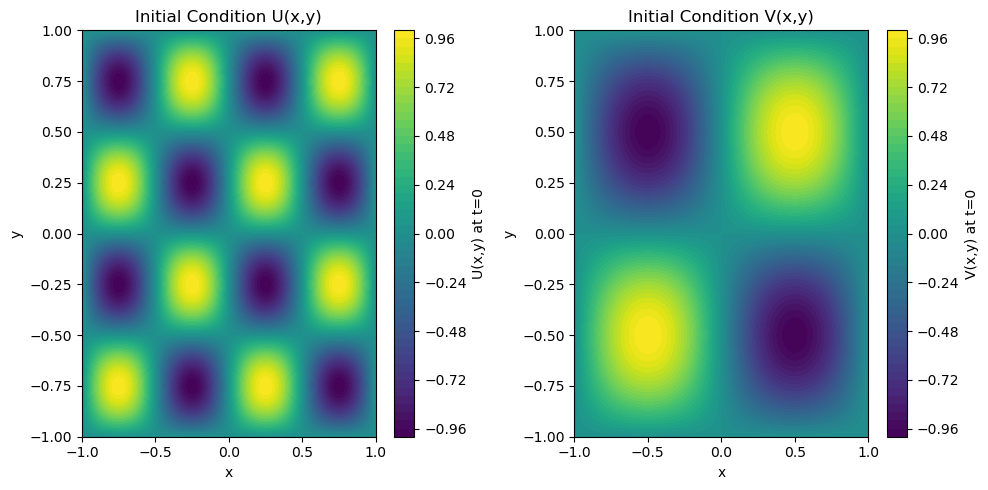

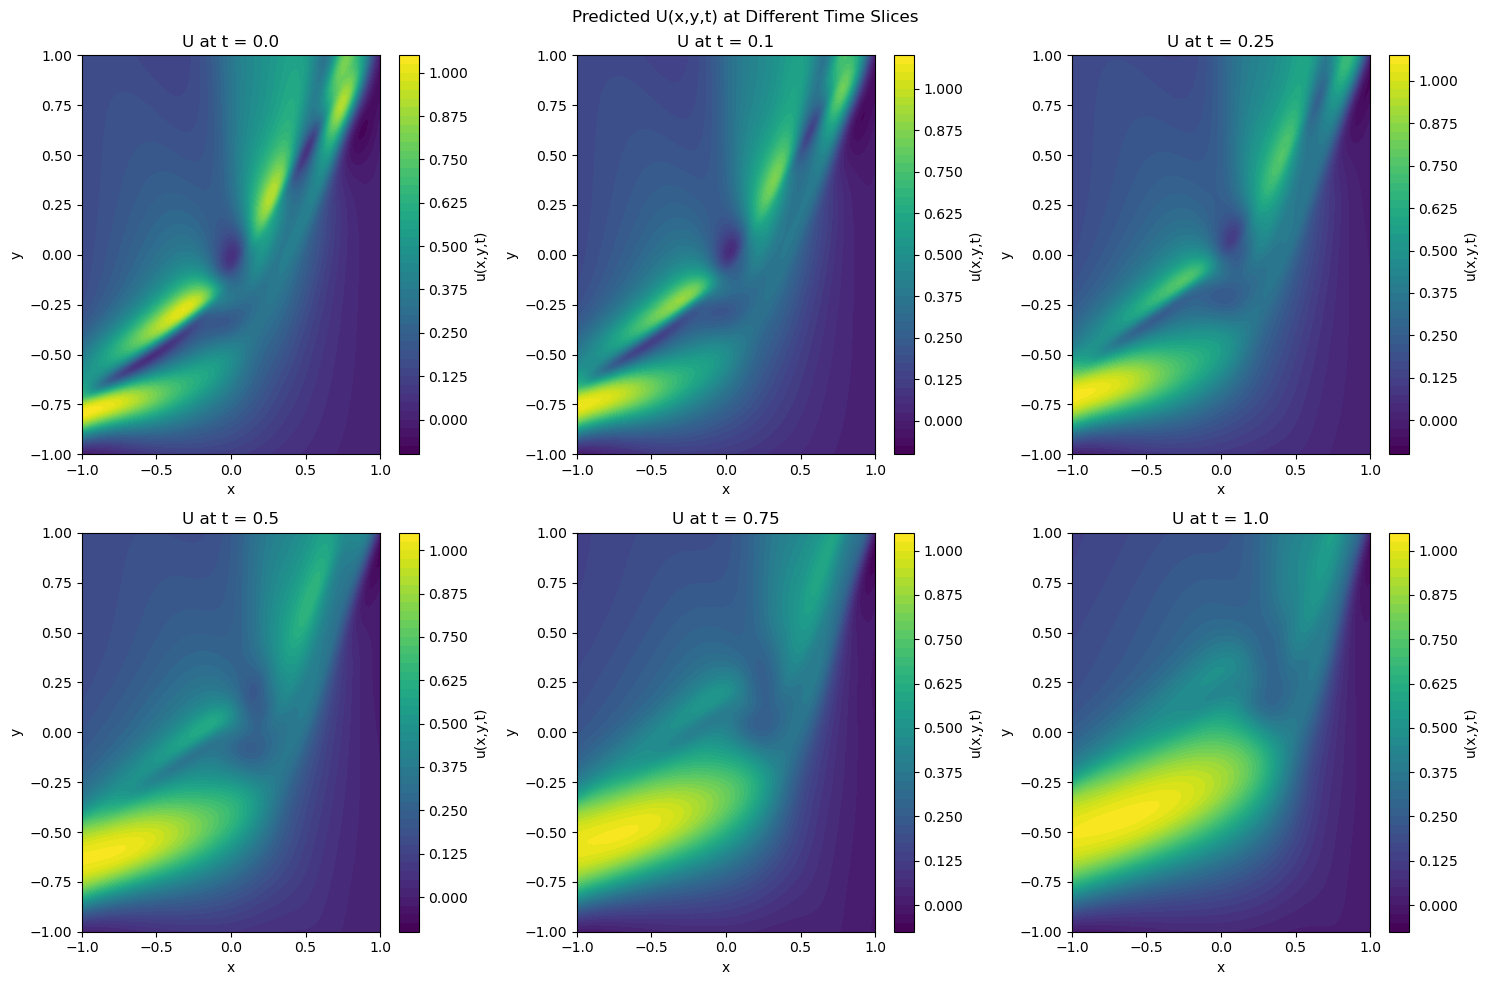

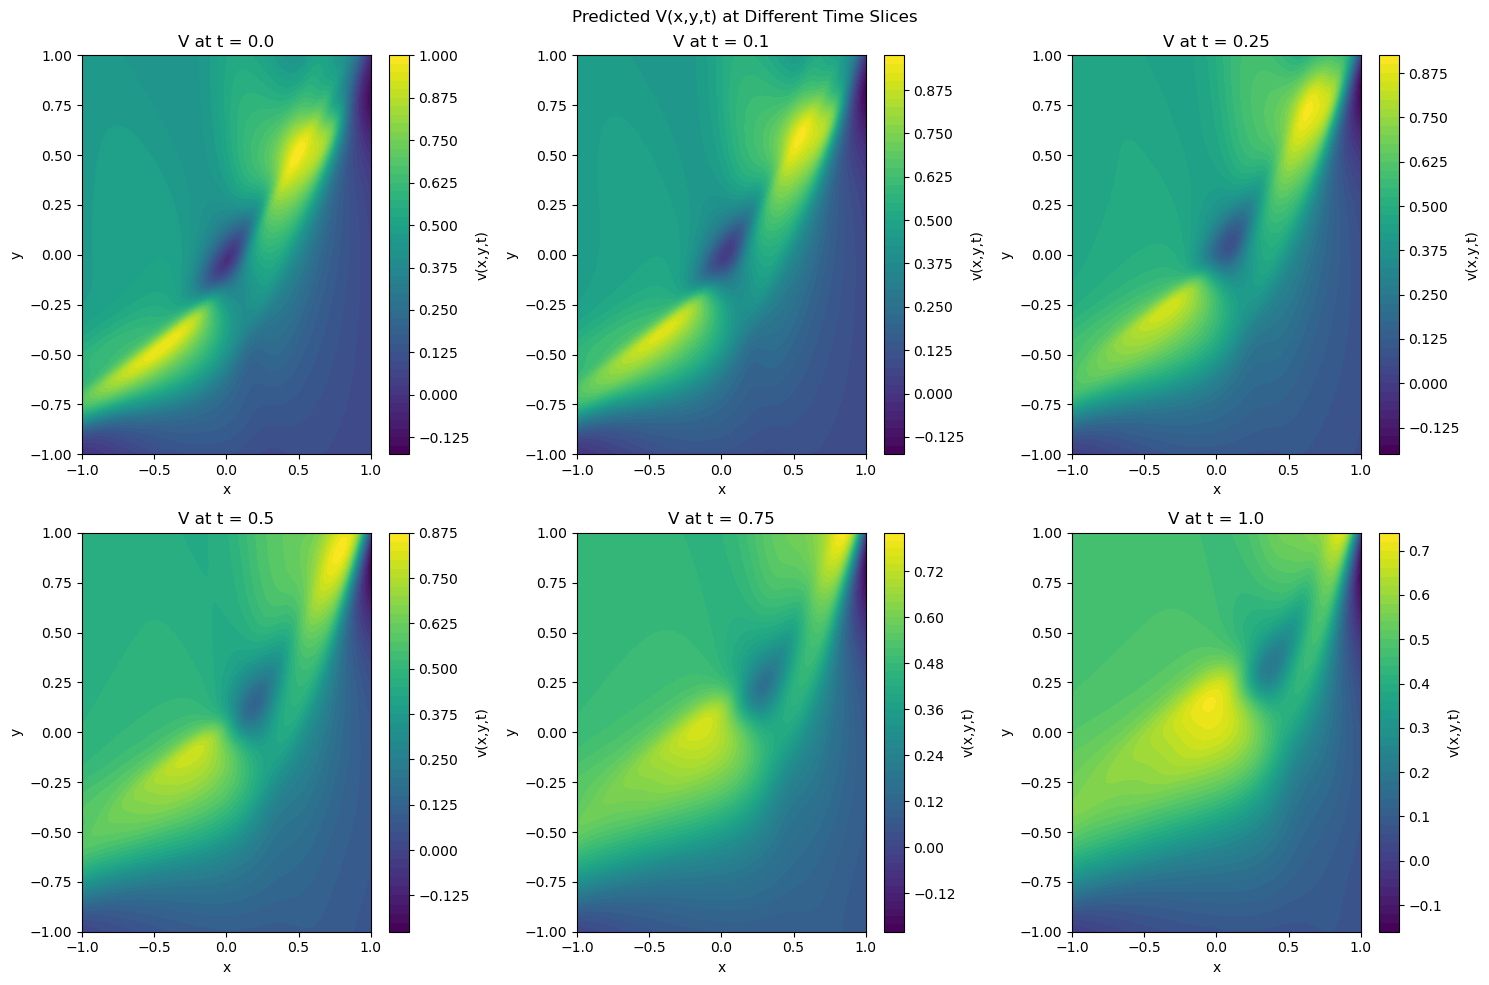

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Plotting Initial Conditions
def plot_initial_conditions():
    # Create meshgrid for initial conditions
    x_init = np.linspace(x_min, x_max, 200)
    y_init = np.linspace(y_min, y_max, 200)
    xx_init, yy_init = np.meshgrid(x_init, y_init)

    # Compute initial conditions
    U_init = np.sin(2*np.pi * xx_init) * np.sin(2*np.pi * yy_init)
    V_init = np.sin(np.pi * xx_init) * np.sin(np.pi * yy_init)

    # Plot U initial condition
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    contour_u = plt.contourf(xx_init, yy_init, U_init, levels=50, cmap='viridis')
    plt.colorbar(contour_u, label='U(x,y) at t=0')
    plt.title('Initial Condition U(x,y)')
    plt.xlabel('x')
    plt.ylabel('y')

    # Plot V initial condition
    plt.subplot(1, 2, 2)
    contour_v = plt.contourf(xx_init, yy_init, V_init, levels=50, cmap='viridis')
    plt.colorbar(contour_v, label='V(x,y) at t=0')
    plt.title('Initial Condition V(x,y)')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.tight_layout()
    plt.show()

# Prediction and Plotting Function
def predict_and_plot():
    # Prediction grid
    N_x, N_t = 256, 100
    x = np.linspace(x_min, x_max, N_x)
    y = np.linspace(y_min, y_max, N_x)
    t = np.linspace(t_min, t_max, N_t)

    # Preallocate arrays for predictions
    u_preds = np.zeros((N_t, N_x, N_x), dtype=np.float32)
    v_preds = np.zeros((N_t, N_x, N_x), dtype=np.float32)

    # Create meshgrid
    xx, yy = np.meshgrid(x, y)
    xy_flat = np.stack([xx.flatten(), yy.flatten()], axis=1)

    # Prediction
    model.eval()
    with torch.no_grad():
        for i, ti in enumerate(t):
            # Prepare input for this time slice
            tt_col = np.full((xy_flat.shape[0], 1), ti, dtype=np.float32)
            input_np = np.hstack([xy_flat.astype(np.float32), tt_col])
            input_t = torch.tensor(input_np, dtype=torch.float32).to(device)
            
            # Predict
            uv = model(input_t).cpu().numpy()
            
            # Reshape predictions
            u = uv[:, 0].reshape(N_x, N_x)
            v = uv[:, 1].reshape(N_x, N_x)
            
            u_preds[i] = u
            v_preds[i] = v

    # Select time slices to plot
    time_slices = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]

        # Plot U predictions
    plt.figure(figsize=(15, 10))
    for j, ts in enumerate(time_slices, 1):
        idx = int(ts * (N_t - 1))
        plt.subplot(2, 3, j)
        contour_u = plt.contourf(xx, yy, u_preds[idx], levels=50, cmap='viridis')
        plt.colorbar(contour_u, label='u(x,y,t)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'U at t = {ts}')

    plt.suptitle('Predicted U(x,y,t) at Different Time Slices')
    plt.tight_layout()
    plt.show()

    # Plot V predictions
    plt.figure(figsize=(15, 10))
    for j, ts in enumerate(time_slices, 1):
        idx = int(ts * (N_t - 1))
        plt.subplot(2, 3, j)
        contour_v = plt.contourf(xx, yy, v_preds[idx], levels=50, cmap='viridis')
        plt.colorbar(contour_v, label='v(x,y,t)')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(f'V at t = {ts}')

    plt.suptitle('Predicted V(x,y,t) at Different Time Slices')
    plt.tight_layout()
    plt.show()

# Combine both plotting functions
def visualize_pinn_results():
    # Plot initial conditions
    plot_initial_conditions()
    
    # Plot predictions at different time slices
    predict_and_plot()

# Call the visualization function
visualize_pinn_results()


In [42]:
# Plot u and v on x-y plane for several time slices (2D case)
N_x, N_t = 256, 100
x = np.linspace(x_min, x_max, N_x)
y = np.linspace(y_min, y_max, N_x)
t = np.linspace(t_min, t_max, N_t)

# Preallocate arrays for predictions: shape (N_t, N_x, N_x)
u_preds = np.zeros((N_t, N_x, N_x), dtype=np.float32)
v_preds = np.zeros((N_t, N_x, N_x), dtype=np.float32)

# Use model to predict on the full x-y grid for each time slice
xx, yy = np.meshgrid(x, y)  # shape (N_x, N_x)
xy_flat = np.stack([xx.flatten(), yy.flatten()], axis=1)  # shape (N_x*N_x, 2)

model.eval()
with torch.no_grad():
    for i, ti in enumerate(t):
        # build input [x, y, t] for this time slice
        tt_col = np.full((xy_flat.shape[0], 1), ti, dtype=np.float32)
        input_np = np.hstack([xy_flat.astype(np.float32), tt_col])  # (N_x*N_x, 3)
        input_t = torch.tensor(input_np, dtype=torch.float32).to(device)
        uv = model(input_t).cpu().numpy()  # (N_x*N_x, 2)
        u = uv[:, 0].reshape(N_x, N_x)
        v = uv[:, 1].reshape(N_x, N_x)
        u_preds[i] = u
        v_preds[i] = v

# Select time slices to plot
time_slices = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]

for ts in time_slices:
    idx = int(ts * (N_t - 1))
    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, u_preds[idx], levels=100, cmap='viridis')
    plt.colorbar(label='u(x,y,t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Predicted u(x,y) at t={ts}")
    plt.show()

for ts in time_slices:
    idx = int(ts * (N_t - 1))
    plt.figure(figsize=(8, 5))
    plt.contourf(xx, yy, v_preds[idx], levels=100, cmap='viridis')
    plt.colorbar(label='v(x,y,t)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Predicted v(x,y) at t={ts}")
    plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1